In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import sys
import os
import glob
import datetime
from scipy import stats
import gsw
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

### AutoBOD processing only (analysis in separate notebook)

Whenever the AutoBOD is reset (turned off and on again), it initializes from a preset date. For this cruise, that was Jan. 1, 2022.

In [2]:
autoBOD_start_date = datetime.datetime(2022, 1, 1)

In [19]:
# Location of log files from AutoBOD

log_dir = '../respiration/' \
                        'logs/AutoBOD_logs/'

In [20]:
# Location of metadata CSV
log_sheet = pd.read_csv('../respiration/'\
          'logs/AutoBOD_digital_log_sheet.csv')

In [21]:
log_sheet.head()

,Bottle,Bottle_ID,Cast_Niskin,Logfile,AutoBOD_start_time_UTC,Depth,Notes
0,1,C1N11_2,C1N11,C001_021822_autoBOD.log,2/18/22 14:35,525,NaN
1,2,C1N7_2,C1N7,C001_021822_autoBOD.log,2/18/22 14:35,300,NaN
2,3,C1N3_1,C1N3,C001_021822_autoBOD.log,2/18/22 14:35,73,NaN
3,4,C1N3_2,C1N3,C001_021822_autoBOD.log,2/18/22 14:35,73,NaN
4,5,C1N5_1,C1N5,C001_021822_autoBOD.log,2/18/22 14:35,188,NaN


### A series of calculations to get $O_2$ from phase and bottle temperature

In [6]:
### Functions to convert phase angle to oxygen concentration given bottle temperature 

def calc_airsat_o2_conc(phase, IRBotT, Sal):
    
    from numpy import tan, pi, sqrt, exp, log
    
    #Defining constants 
    cal0 = 60.21 #B6
    cal100 = 27.42 #B7
    airpres = 981 #B8
    T0 = 20 #E6
    T100 = 20 #E7
    dF_k = -0.0847 #B12
    f1 = 0.833 #B11
    dksv_k = 0.000416 #B13
    m = 34 #B14
    
    #Salinity-related corrections
    # http://www.argodatamgt.org/content/download/26531/181223/file/Aanderaa_TD218_OperatingManual_OxygenOptode_3830_3835_3930_3975_4130_4175_RevApr2007.pdf
    Ts_eq = lambda t: np.log((298.15 - t)/(273.15 + t)) #scaled temperature, depends on temperature of incubation
    B0 = -6.24097e-3
    C0 = -3.1168e-7
    B1 = -6.93498e-3
    B2= -6.90358e-3
    B3 = -4.29155e-3
    
    tan_psi0_t100 = tan(((cal0+dF_k*(T100-T0)))*pi/180) #D11
    tan_psi100_t100 = tan(cal100*pi/180) #D13

    A = tan_psi100_t100/tan_psi0_t100*1/m*100**2 #F11
    B = tan_psi100_t100/tan_psi0_t100*100+tan_psi100_t100/tan_psi0_t100*100/m-f1*100/m-100+f1*100 #F12
    C = tan_psi100_t100/tan_psi0_t100-1 #F13

    ksv_t100 = (-B+sqrt(B**2-4*A*C))/(2*A) #H11
    
    air_sat = (-((tan(phase*pi/180))/(tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*
                        (ksv_t100+(dksv_k*(IRBotT-T100)))+(tan(phase*pi/180))/
                        (tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*1/m*(ksv_t100+(dksv_k
                        *(IRBotT-T100)))-f1*1/m*(ksv_t100+(dksv_k*(IRBotT-T100)))-(ksv_t100
                        +(dksv_k*(IRBotT-T100)))+f1*(ksv_t100+(dksv_k*(IRBotT-T100))))+(
                        sqrt(((((tan(phase*pi/180))/(tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*(
                        ksv_t100+(dksv_k*(IRBotT-T100)))+(tan(phase*pi/180))/(tan((cal0+(dF_k*(
                        IRBotT-T0)))*pi/180))*1/m*(ksv_t100+(dksv_k*(IRBotT-T100)))-
                        f1*1/m*(ksv_t100+(dksv_k*(IRBotT-T100)))-(ksv_t100+(dksv_k*
                        (IRBotT-T100)))+f1*(ksv_t100+(dksv_k*(IRBotT-T100))))**2))-
                        4*((tan(phase*pi/180))/(tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*1/m*
                        ((ksv_t100+(dksv_k*(IRBotT-T100)))**2))*((tan(phase*pi/180))/(
                        tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))-1))))/(2*((tan(phase*pi/180))/
                        (tan((cal0+(dF_k*(IRBotT-T0)))*pi/180))*1/m*((ksv_t100+(dksv_k*(IRBotT-T100)))**2)))


    o2_conc = (((airpres-exp(52.57-6690.9/(273.15+IRBotT)-4.681*log(273.15+IRBotT)))/1013)*
           air_sat/100.*0.2095*(48.998-1.335*IRBotT+0.02755*IRBotT**2-
                                 0.000322*IRBotT**3+0.000001598*IRBotT**4)*32/22.414)
    
    #Salinity correction
    Ts = Ts_eq(IRBotT)
    o2_conc*=np.exp(Sal*(B0 + B1*Ts+ B2*Ts**2 + B3*Ts**3) + C0*Sal**2)
    
    o2_conc *= 31.25 #umol/L
    
    return o2_conc

In [7]:
def bottle_add_data(ds, log_sheet):
    ds['Depth'] = (('N_bottles',), log_sheet['Depth'])
    notes = log_sheet['Notes'].astype('str').replace({'nan': ' '})
    ds['Notes'] = (('N_bottles',), notes)
    ds['Cast_Niskin'] = (('N_bottles'), log_sheet['Cast_Niskin'])
    UTC_dates = np.repeat(pd.to_datetime(log_sheet['AutoBOD_start_time_UTC']).values, 
          ds.dims['N_obs']).reshape((ds.dims['N_bottles'], 
                    ds.dims['N_obs'])) + ds['Elapsed_time_seconds']
    #ds['UTC_datetime'] = UTC_dates
    return ds

In [8]:
#This function takes in a list of datasets with different number of observations and pads them to the length of
#the most number of obs, then outputs the result as another list 

def standardize_Nobs(ds_list):
    max_nobs = max([ds.dims['N_obs'] for ds in ds_list])
    ds_list_standardized = []
    for ds in ds_list:
        ds = ds.pad(N_obs = (0, max_nobs - ds.dims['N_obs']))
        ds_list_standardized.append(ds)
    return ds_list_standardized, max_nobs

In [9]:
def datetime_from_date_hour(date_hour_df):
    # Input a pandas series with date ('M/D/y') and hour ('H:M:S') date
    # convert into datetime object
    hh_mm_ss = date_hour_df['Hour'].str.split(':', expand=True)
    datetime_df = pd.to_datetime(date_hour_df['Date']) + \
                        pd.to_timedelta(hh_mm_ss[0].astype('int')*60*60 + hh_mm_ss[1].astype('int')*60 + \
                    hh_mm_ss[2].astype('int'), unit='sec')
    return datetime_df

In [12]:
def autobod_processing(log_sheet, error_codes=[1, 5], logging_on=False):
    Sal = 38.4 #adjust per location

    log_sheet_unique = log_sheet[['Bottle_ID', 'Depth', 
            'AutoBOD_start_time_UTC', 'Notes', 'Cast_Niskin']].drop_duplicates(subset=['Bottle_ID'])
    
    for i, logfile in enumerate(sorted(list(set(log_sheet['Logfile'].values)))):
        if logging_on:
            print(logfile)

        ### Calculate oxygen concentration and other parameters of interest ###
        
        cols = ['Amplitude', 'Phase', 'Optode_Calculated_O2', 'Error', 'Encoder', 'Bottle', 'Sample', 
            'Date', 'Hour', 'IRDetT', 'IRBotT', 'Steps', 'Light']
        run = pd.read_csv(log_dir + logfile, skiprows=4, skipfooter=3, names = cols,
                    sep='\s+', engine='python')
        run['Phase'] = run['Phase']/100 #Divide phase by 100 to get accurate results

        run['autoBOD_datetime'] = datetime_from_date_hour(run[['Date', 'Hour']])

        # Get relative number of seconds elapsed by subtracting the time logged by the autoBOD from its start time (1/1/22)
        run['Elapsed_time_seconds'] = run['autoBOD_datetime'] - autoBOD_start_date

        # Remove all data where error is not in the list of error codes provided (default 1 or 5)
        run = run.where(run.Error.isin(error_codes))
        run = run.dropna()

        #Calculate oxygen concentration
        run['O2_conc_umol_L'] = calc_airsat_o2_conc(run['Phase'], run['IRBotT'], Sal)

        # Get a counter of the number of measurements made (i.e., because the autoBOD records 
        # multiple data points when it finds a spot, and we might want to average these measurements). For example, if it takes 10 measurements
        # the measurement number will increment by 1 every 10 observations (when the Sample field resets)
        run['measurement_number'] = ((run['Sample'] - run['Sample'].shift(1)) < 0).cumsum() + 1

        ### Extract data by bottle and put into xarray dataset so we can track auxiliary variables ###
        
        run_log = log_sheet[log_sheet['Logfile'] == logfile] #log_sheet just for this particular run on the AutoBOD

        ds_list = []

        for bottle in run_log['Bottle']:
            df = run[run['Bottle'] == bottle] #select just data from one bottle
            bottle_id = run_log[run_log['Bottle'] == bottle]['Bottle_ID'].values #get bottle ID
            ds = df.to_xarray().drop('index').rename_dims({'index': 'N_obs'}) #convert to xarray with index as the number of measurements
            ds = ds.expand_dims("N_bottles").assign_coords(Bottle_ID=("N_bottles", bottle_id)) # add additional dimension for number of bottles
            # this will make it easier to concatenate down the line
            utc_start_time = run_log[run_log['Bottle'] == bottle]['AutoBOD_start_time_UTC'].values #start time as recorded in the log_file
            ds['UTC_datetime'] = (("N_obs",), pd.to_datetime(utc_start_time[0]) 
                                  + run[run['Bottle'] == bottle]['Elapsed_time_seconds'].values) #adding elapsed time to the recorded start time so that we
            # have the observations in UTC time, so we can concatenate with other runs
            ds_list.append(ds)

        # If this is the first file, then pad to the length of the bottle with the most observations, then concatenate into one dataset    
        if i == 0:
            ds_list, _ = standardize_Nobs(ds_list)
            master_ds = xr.concat(ds_list, dim = 'N_bottles')

        # Else if we already have an existing dataset, we want to concatenate observations from the same bottle together
        elif i > 0:
            updated_ds_list = []
            nonupdated_dataset = master_ds.copy()

            for ds in ds_list:
                bottle_id = ds.Bottle_ID.values
                if bottle_id in master_ds.Bottle_ID.values: # are there previous observations of this bottle_id in the master_ds already?
                    # Remove observations for this bottle from the master dataset, which we have now called nonupdated_dataset
                    nonupdated_dataset = nonupdated_dataset.where(nonupdated_dataset.Bottle_ID != bottle_id, drop=True)
                    updated_ds = xr.concat([master_ds.sel(N_bottles = 
                                master_ds.Bottle_ID == bottle_id), ds], dim='N_obs') # concatenate the new observations for this bottle with the 
                    # existing observations
                    updated_ds_list.append(updated_ds)
                else:
                    updated_ds_list.append(ds)

            updated_ds_list, max_nobs = standardize_Nobs(updated_ds_list) # pad to the length of the bottle with the most observations
            nonupdated_dataset = nonupdated_dataset.pad(N_obs = (0, max_nobs - nonupdated_dataset.dims['N_obs'])) #also padding this dataset so it has 
            # the same number of observations
            master_ds = xr.concat(updated_ds_list + [nonupdated_dataset], dim='N_bottles') #concatenate both datasets

    master_ds = master_ds.sortby('Bottle_ID')
    log_sheet_unique = log_sheet_unique.sort_values(by='Bottle_ID')
    master_ds = bottle_add_data(master_ds, log_sheet_unique) #Add relevant metadata, including depth of the measurement and cast and Niskin
    
    return master_ds

In [13]:
master_ds = autobod_processing(log_sheet, logging_on=True)

C001_021822_autoBOD-1.log
C001_021822_autoBOD.log
C002_021922_autoBOD.log
Run003_022122_autoBOD.log
Run004_022122_autoBOD.log
Run005_022122_autoBOD.log
Run006_022222_autoBOD.log
Run007_022322_autoBOD.log
Run008_022322_autoBOD.log
Run009_022322_autoBOD.log
Run010_022322_autoBOD.log
Run011_022322_autoBOD.log
Run012_022322_autoBOD.log
Run013_022422_autoBOD.log
Run014_022422_autoBOD.log
Run015_022522_autoBOD.log
Run016_022522_autoBOD.log
Run017_022522_autoBOD.log
Run018_022622_autoBOD.log
Run019_022622_autoBOD.log
Run020_022622_autoBOD.log
Run021_022622_autoBOD.log
Run022_022722_autoBOD.log
Run023_022722_autoBOD.log
Run024_022722_autoBOD.log
Run025_022722_autoBOD.log
Run026_022822_autoBOD.log
Run027_022822_autoBOD.log
Run028_022822_autoBOD.log
Run029_022822_autoBOD.log
Run030_030122_autoBOD.log
Run031_030122_autoBOD.log
Run032_030122_autoBOD.log
Run033_030122_autoBOD.log
Run034_030222_autoBOD.log
Run035_030322_autoBOD.log
Run036_030322_autoBOD.log
Run037_030322_autoBOD.log
Run038_030322_au

In [17]:
master_ds.to_netcdf('../respiration/autoBOD_respiration_rates.nc')

### For sanity check, look at some plotted timeseries of oxygen concentration from different samples

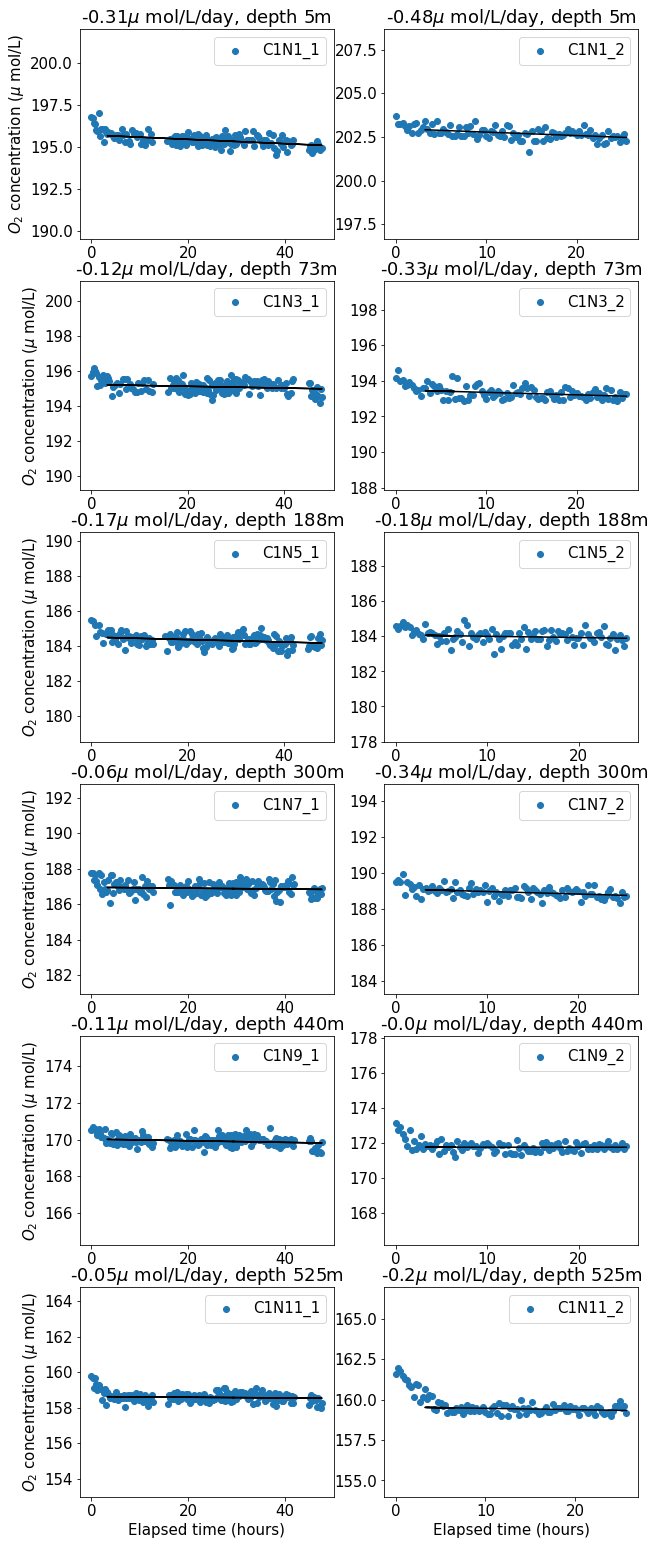

In [16]:
#ids = ['C1N1_1', 'C1N1_2', 'C1N3_1', 'C1N3_2', 'C6N15_1', 'C6N15_3']
 
ids = ['C15N16_1', 'C12N18_1', 'C12N18_2', 'C12N18_3', 'C14N13_1', 'C14N13_2', 'C14N13_3',
      'C16N14_1', 'C16N14_2', 'C10N18_1', 'C10N18_2']

ids = ['C1N1', 'C1N3', 'C1N5', 'C1N7', 'C1N9', 'C1N11']
    
fig, axes = plt.subplots(len(ids), 2, figsize = (10,4.5*len(ids)))

for j, val in enumerate(ids):
    
    for i in range(2):
        bid = val + '_' + str(i+1)
        test = master_ds.isel(N_bottles = master_ds.Bottle_ID == bid)
        test['time_float'] = test.UTC_datetime.astype('float')
        grpby = test.to_dataframe().groupby('measurement_number').agg({'O2_conc_umol_L': np.nanmean,
                                            'IRBotT': np.nanmean, 'time_float': np.nanmean})

        axis_time = grpby.time_float.values - np.nanmin(grpby.time_float.values)
        axes[j, i].scatter(axis_time/(1e9*60*60), grpby.O2_conc_umol_L, label=bid)
        
        #Try to fit a polyline
        remove_outliers = True
        start_point = 3
        #Per Paul, temperature of bottle has equilibrated by ~30 minutes (per Ben, a few hours) after putting on bottle

        polyfit_resp_rates = []
        time_vals = axis_time/(1e9*60*60)
        time_ind = time_vals >= start_point
        time_vals = time_vals[time_ind]
        o2_vals = grpby.O2_conc_umol_L.values
        o2_vals = o2_vals[time_ind]
        nan_ind = ~np.isnan(o2_vals)

        #Remove outliers, i.e. with a zcore 
        if remove_outliers:
            outlier_ind = (np.abs(stats.zscore(o2_vals[nan_ind])) < 3)
        else:
            outlier_ind = np.ones(len(o2_vals[nan_ind])).astype('bool')
        p = np.polyfit(time_vals[nan_ind][outlier_ind], o2_vals[nan_ind][outlier_ind], deg=1)
        polyfit_resp_rates.append(p[0])
        #p = np.polyfit(time_vals[nan_ind], np.log(o2_vals)[nan_ind], deg=1)
        
        axes[j, i].plot(time_vals[nan_ind], p[0]*time_vals[nan_ind] + p[1], color='black')
        
        if j == len(ids) - 1:
            axes[j, i].set_xlabel('Elapsed time (hours)')
        if i == 0:
            axes[j, i].set_ylabel(r'$O_2$ concentration ($\mu$ mol/L)')

        
        axes[j, i].set_ylim(np.nanmin(grpby.O2_conc_umol_L.values) - 5, 
                         np.nanmax(grpby.O2_conc_umol_L.values) + 5)

        axes[j, i].legend()
        
        axes[j, i].set_title(str(np.round(p[0]*24, 2)) + r'$\mu$ mol/L/day' +\
                          ', depth '+ str(test.Depth.values[0]) + 'm')
        
        np.round(p[0]*24, 2)
